<a href="https://colab.research.google.com/github/wowthecoder/Image-Classification-Tutorial/blob/main/Facial_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup and Load Data

### 1.1 Installing Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib


---


In [1]:
import tensorflow as tf
import os

In [2]:
#Avoid OOM(Out of Memory) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 1.2 Load data from Kaggle

In [3]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install Kaggle

In [5]:
%cd /content/gdrive/MyDrive/ML_Datasets/

/content/gdrive/MyDrive/ML_Datasets


In [6]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/ML_Datasets/" 

In [ ]:
!kaggle datasets download -d msambare/fer2013

---

Now unzip the dataset.

In [ ]:
!unzip fer2013.zip -d facial_emotions

### 1.3 Load Data

In [103]:
import numpy as np
from matplotlib import pyplot as plt

data = tf.keras.utils.image_dataset_from_directory('facial_emotions/train', batch_size=64, image_size=(48, 48), color_mode='grayscale')

Found 28709 files belonging to 7 classes.


In [93]:
data_iterator = data.as_numpy_iterator()
# Get another batch from the iterator
batch = data_iterator.next()

The code below shows that in 1 batch, there are 32 images of size 48x48px, and each image has 1 color channel(grayscale)

In [94]:
# Images represented as numpy arrays
batch[0].shape

(32, 48, 48, 1)

There are 7 classes so the labels are numbered 0-6.

In [95]:
# The image labels
batch[1]

array([0, 2, 4, 6, 6, 0, 2, 4, 4, 2, 4, 3, 3, 5, 3, 2, 5, 5, 5, 3, 6, 0,
       5, 5, 3, 3, 0, 5, 3, 4, 3, 3], dtype=int32)

Check which number is assigned to which label.

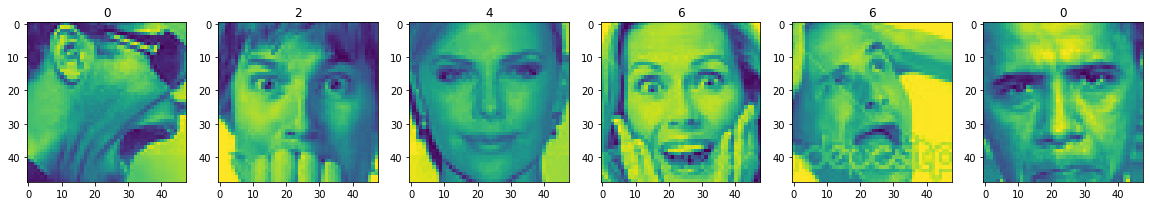

In [102]:
fig, ax = plt.subplots(ncols=6, figsize=(20, 20))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img.squeeze())
    ax[idx].title.set_text(batch[1][idx])


*   0: angry
*   1: disgust
*   2: fear
*   3: happy
*   4: neutral
*   5: sad
*   6: surprise









# 2. Preprocess Data

### 2.1 Scale Data

Scale our data values from 0-255(RGB values) to 0-1

In [104]:
# x represents the image data, y represents the labels
data = data.map(lambda x, y: (x/255, y))

The code below is for testing.

In [105]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()

1.0

### 2.2 Split Data

In [106]:
# The number of batches of data
len(data)

898

In [107]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.2)+1
print(train_size, val_size)

718 180


In [108]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)

# 3. Deep Learning

### 3.1 Build Deep Learning Model

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

model = Sequential([
    # Add padding later
    Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(),

    Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),

    Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),

    Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),

    Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),

    Flatten(),
    Dense(units=512, activation='relu'),
    Dropout(0.5),
    Dense(units=256, activation='relu'),
    Dropout(0.5),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    # softmax for multi-class classification
    Dense(units=7, activation='softmax'),
])

In [111]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [112]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 23, 23, 64)        36928     
                                                                 
 batch_normalization_10 (Bat  (None, 23, 23, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                      

### 3.2 Train Model

In [118]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [119]:
logdir='facial_emotions/logs'

Callback functions:
1.   **ReduceLROnPlateau**
> This function monitors the validation loss for signs of a plateau and then modify the learning rate by the specified factor when a plateau is detected.





In [120]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3)

2.   **EarlyStopping**

> The function waits for a number of epochs and terminates the training if no change in the parameter is found.





In [121]:
early_stopping = EarlyStopping(
    monitor='val_acc',
    min_delta=0.001,
    patience=6,
    restore_best_weights=True,
)

3.   **ModelCheckpoint**

> Saves the model after every epoch. In case training stops, we can load the checkpoint and resume the progress.









In [122]:
checkpointer = ModelCheckpoint(
    filepath=logdir,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
)

In [123]:
hist = model.fit(
    train,
    epochs=100,
    batch_size=64,
    validation_data=val,
    callbacks=[lr_reducer, early_stopping, checkpointer],
)

Epoch 1/100


ValueError: ignored

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'])